In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


# Credit Card Fraud Detection
 Using Keras & AutoEncoders

In [1]:
#!kaggle datasets download -d mlg-ulb/creditcardfraud
filePath = '/tmp/dataset'
fileName = 'creditcard.csv'
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('mlg-ulb/creditcardfraud', path=filePath, unzip=True)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
SEED = 42
df = pd.read_csv(filePath + '/' + fileName)
df[:5]
df.isnull().values.any()

False

In [4]:
'''Splitting X & Y'''
Y = df['Class']
X = df.drop(['Class'], axis=1)
X[:3]
Y[Y==1].shape                           #Total Fraud Classes
df[df['Class']==1].Amount.describe()    #Fraud Amount
df[df['Class']==0].Amount.describe()    #Non_fraud

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

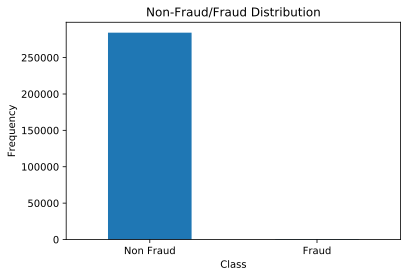

In [5]:
# Plotting Time of Fraud Happen & Fraud Amount
Y.value_counts(sort=True).plot(kind='bar', rot=0)
plt.title('Non-Fraud/Fraud Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(2), ['Non Fraud', 'Fraud'])
plt.show()

In [6]:
'''
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of Transaction vs. Amount/Class')
ax1.scatter(df[df['Class']==0].Time, df[df['Class']==0].Amount)
ax1.set_title('Non-Fraud')
ax2.scatter(df[df['Class']==1].Time, df[df['Class']==1].Amount)
ax2.set_title('Fraud')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()
'''

"\nf, (ax1, ax2) = plt.subplots(2, 1, sharex=True)\nf.suptitle('Time of Transaction vs. Amount/Class')\nax1.scatter(df[df['Class']==0].Time, df[df['Class']==0].Amount)\nax1.set_title('Non-Fraud')\nax2.scatter(df[df['Class']==1].Time, df[df['Class']==1].Amount)\nax2.set_title('Fraud')\nplt.xlabel('Time')\nplt.ylabel('Amount')\nplt.show()\n"

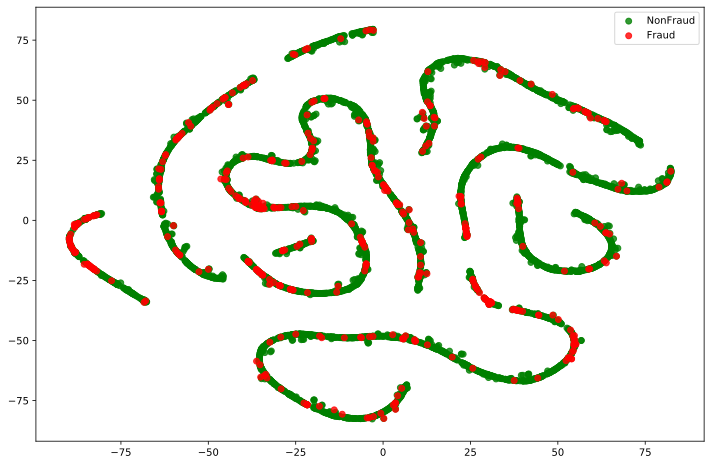

In [7]:
'''visualize the nature of fraud and non-fraud transactions using T-SNE. 
T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique 
which reduced the dimentions of data and produces only top n components with maximum information
'''
from sklearn.manifold import TSNE
non_fraud = df[df['Class'] == 0].sample(5000)
fraud = df[df['Class'] == 1]
df_viz = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
x_viz = df_viz.drop(['Class'], axis=1).values
y_viz = df_viz['Class'].values

def tnse_plot(x, y):
    tsne = TSNE(n_components=2, random_state=0)
    x_t = tsne.fit_transform(x)
    #print(x_t)    
    plt.figure(figsize=(12, 8))
    plt.scatter(x_t[np.where(y == 0), 0], x_t[np.where(y == 0), 1], 
        marker='o', color='g', linewidths='1', alpha=0.8, label='NonFraud')
    plt.scatter(x_t[np.where(y == 1), 0], x_t[np.where(y == 1), 1], 
        marker='o', color='r', linewidths='1', alpha=0.8, label='Fraud')
    
    plt.legend(loc='best')
    plt.show()

tnse_plot(x_viz, y_viz)

In [8]:
'''Spliting Train/Test'''
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
train_x, test_x, train_y, test_y = train_test_split(X, Y, random_state=SEED)

'''Deleting Time Column as doing Feature Scaling & Reseting Row Indexes'''
train_x = train_x.drop(['Time'], axis=1).reset_index(drop=True)
train_y = train_y.reset_index(drop=True)

test_x = test_x.drop(['Time'], axis=1).reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

In [9]:
'''Network: Auto-Encoder'''
from keras import Sequential, optimizers
from keras.layers import Dense
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

np.random.seed(SEED)
def auto_encoder(input_dim):
    autoencoder = Sequential([
        #Encoder
        Dense(units=200, activation='tanh', 
            kernel_initializer = 'glorot_uniform',        
            activity_regularizer=regularizers.l2(0.0001),
            input_shape = (input_dim,)),
        Dense(units=50, activation='relu'),
        #Decoder
        Dense(units=50, activation='tanh', input_shape=(50,)),
        Dense(units=200, activation='tanh'),
        Dense(units=input_dim, activation='relu')
    ])
    autoencoder.summary()    
    return autoencoder

def encoder_form_auto_encoder(model):
    encoder = Sequential([
        model.layers[0],
        model.layers[1]
    ])
    return encoder

Using TensorFlow backend.


In [10]:
train_fraud, train_non_fraud = train_x[train_y == 1], train_x[train_y == 0]
train_fraud = preprocessing.MinMaxScaler().fit_transform(train_fraud)           #Can't do Feature Scalling Globally otherwise above line will break
train_non_fraud = preprocessing.MinMaxScaler().fit_transform(train_non_fraud)   #Can't do fraud/Non-Fraud segrigation
'''For Self Ref. Before Cleanup
#train_non_fraud = train_non_fraud.drop(['Time'], axis=1).reset_index(drop=True)
#train_non_fraud = preprocessing.MinMaxScaler().fit_transform(train_non_fraud.iloc[:, 1:])   #.iloc[:, 1:]: Excluding Index Column as added after reset_index(drop=False)
'''

"For Self Ref. Before Cleanup\n#train_non_fraud = train_non_fraud.drop(['Time'], axis=1).reset_index(drop=True)\n#train_non_fraud = preprocessing.MinMaxScaler().fit_transform(train_non_fraud.iloc[:, 1:])   #.iloc[:, 1:]: Excluding Index Column as added after reset_index(drop=False)\n"

In [11]:
'''Summarize history for accuracy'''
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('accuracy & loss')
    plt.ylabel('accuracy & loss')
    plt.xlabel('epoch')
    plt.show()

W0711 00:07:44.434243 139976782825280 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 00:07:44.436191 139976782825280 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 00:07:44.438429 139976782825280 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 00:07:44.501118 139976782825280 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0711 00:07:44.721775 139976782825280 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               6000      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_5 (Dense)              (None, 29)                5829      
Total params: 34,629
Trainable params: 34,629
Non-trainable params: 0
_________________________________________________________________


Train on 112500 samples, validate on 37500 samples


Epoch 1/100


  1500/112500 [..............................] - ETA: 17s - loss: 2.3334 - acc: 0.1960

 15000/112500 [===>..........................] - ETA: 1s - loss: 1.4333 - acc: 0.2794 

 30000/112500 [=======>......................] - ETA: 0s - loss: 0.9547 - acc: 0.4795

 45000/112500 [===========>..................] - ETA: 0s - loss: 0.7041 - acc: 0.5402

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.5485 - acc: 0.5809

 76500/112500 [===================>..........] - ETA: 0s - loss: 0.4606 - acc: 0.6042

 88500/112500 [======================>.......] - ETA: 0s - loss: 0.4106 - acc: 0.6183

 99000/112500 [=========================>....] - ETA: 0s - loss: 0.3764 - acc: 0.6287

112500/112500 [==============================] - 1s 6us/step - loss: 0.3416 - acc: 0.6407 - val_loss: 0.0855 - val_acc: 0.7189


Epoch 2/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0857 - acc: 0.7380

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0841 - acc: 0.7356

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0834 - acc: 0.7415

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0830 - acc: 0.7431

 63000/112500 [===============>..............] - ETA: 0s - loss: 0.0826 - acc: 0.7473

 78000/112500 [===================>..........] - ETA: 0s - loss: 0.0823 - acc: 0.7486

 93000/112500 [=======================>......] - ETA: 0s - loss: 0.0820 - acc: 0.7502

108000/112500 [===========================>..] - ETA: 0s - loss: 0.0818 - acc: 0.7520

112500/112500 [==============================] - 0s 4us/step - loss: 0.0818 - acc: 0.7518 - val_loss: 0.0801 - val_acc: 0.7745


Epoch 3/100


  1500/112500 [..............................] - ETA: 0s - loss: 0.0803 - acc: 0.7993

 15000/112500 [===>..........................] - ETA: 0s - loss: 0.0802 - acc: 0.7664

 30000/112500 [=======>......................] - ETA: 0s - loss: 0.0800 - acc: 0.7680

 45000/112500 [===========>..................] - ETA: 0s - loss: 0.0802 - acc: 0.7661

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0799 - acc: 0.7645

 75000/112500 [===================>..........] - ETA: 0s - loss: 0.0799 - acc: 0.7627

 90000/112500 [=======================>......] - ETA: 0s - loss: 0.0799 - acc: 0.7639

105000/112500 [===========================>..] - ETA: 0s - loss: 0.0799 - acc: 0.7646

112500/112500 [==============================] - 0s 4us/step - loss: 0.0799 - acc: 0.7650 - val_loss: 0.0794 - val_acc: 0.7628


Epoch 4/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0796 - acc: 0.7840

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0789 - acc: 0.7591

 33000/112500 [=======>......................] - ETA: 0s - loss: 0.0793 - acc: 0.7635

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0793 - acc: 0.7668

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0792 - acc: 0.7697

 75000/112500 [===================>..........] - ETA: 0s - loss: 0.0791 - acc: 0.7672

 88500/112500 [======================>.......] - ETA: 0s - loss: 0.0790 - acc: 0.7615

103500/112500 [==========================>...] - ETA: 0s - loss: 0.0790 - acc: 0.7625

112500/112500 [==============================] - 0s 4us/step - loss: 0.0791 - acc: 0.7633 - val_loss: 0.0807 - val_acc: 0.7645


Epoch 5/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0809 - acc: 0.7860

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0791 - acc: 0.7623

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0785 - acc: 0.7662

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0780 - acc: 0.7696

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0777 - acc: 0.7690

 78000/112500 [===================>..........] - ETA: 0s - loss: 0.0775 - acc: 0.7659

 91500/112500 [=======================>......] - ETA: 0s - loss: 0.0770 - acc: 0.7665

106500/112500 [===========================>..] - ETA: 0s - loss: 0.0756 - acc: 0.7685

112500/112500 [==============================] - 0s 4us/step - loss: 0.0753 - acc: 0.7685 - val_loss: 0.0682 - val_acc: 0.7717


Epoch 6/100


  1500/112500 [..............................] - ETA: 0s - loss: 0.0683 - acc: 0.7993

 15000/112500 [===>..........................] - ETA: 0s - loss: 0.0693 - acc: 0.7506

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0677 - acc: 0.7609

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0675 - acc: 0.7671

 63000/112500 [===============>..............] - ETA: 0s - loss: 0.0669 - acc: 0.7703

 78000/112500 [===================>..........] - ETA: 0s - loss: 0.0665 - acc: 0.7621

 93000/112500 [=======================>......] - ETA: 0s - loss: 0.0663 - acc: 0.7434

108000/112500 [===========================>..] - ETA: 0s - loss: 0.0662 - acc: 0.7443

112500/112500 [==============================] - 0s 4us/step - loss: 0.0662 - acc: 0.7457 - val_loss: 0.0652 - val_acc: 0.7791


Epoch 7/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0653 - acc: 0.8033

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0648 - acc: 0.7859

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0649 - acc: 0.7833

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0649 - acc: 0.7820

 63000/112500 [===============>..............] - ETA: 0s - loss: 0.0647 - acc: 0.7818

 79500/112500 [====================>.........] - ETA: 0s - loss: 0.0645 - acc: 0.7768

 96000/112500 [========================>.....] - ETA: 0s - loss: 0.0644 - acc: 0.7720

111000/112500 [============================>.] - ETA: 0s - loss: 0.0643 - acc: 0.7698

112500/112500 [==============================] - 0s 4us/step - loss: 0.0643 - acc: 0.7701 - val_loss: 0.0635 - val_acc: 0.7818


Epoch 8/100


  1500/112500 [..............................] - ETA: 1s - loss: 0.0636 - acc: 0.8007

 18000/112500 [===>..........................] - ETA: 0s - loss: 0.0642 - acc: 0.7868

 34500/112500 [========>.....................] - ETA: 0s - loss: 0.0647 - acc: 0.7818

 51000/112500 [============>.................] - ETA: 0s - loss: 0.0648 - acc: 0.7811

 66000/112500 [================>.............] - ETA: 0s - loss: 0.0647 - acc: 0.7818

 81000/112500 [====================>.........] - ETA: 0s - loss: 0.0644 - acc: 0.7812

 96000/112500 [========================>.....] - ETA: 0s - loss: 0.0643 - acc: 0.7789

112500/112500 [==============================] - 0s 4us/step - loss: 0.0642 - acc: 0.7787 - val_loss: 0.0635 - val_acc: 0.7809


Epoch 9/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0636 - acc: 0.8040

 18000/112500 [===>..........................] - ETA: 0s - loss: 0.0635 - acc: 0.7883

 33000/112500 [=======>......................] - ETA: 0s - loss: 0.0634 - acc: 0.7778

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0635 - acc: 0.7647

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0636 - acc: 0.7675

 76500/112500 [===================>..........] - ETA: 0s - loss: 0.0636 - acc: 0.7702

 93000/112500 [=======================>......] - ETA: 0s - loss: 0.0637 - acc: 0.7724

109500/112500 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.7698

112500/112500 [==============================] - 0s 4us/step - loss: 0.0636 - acc: 0.7701 - val_loss: 0.0624 - val_acc: 0.7812


Epoch 10/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0625 - acc: 0.8033

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0634 - acc: 0.7878

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0632 - acc: 0.7860

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0631 - acc: 0.7835

 64500/112500 [================>.............] - ETA: 0s - loss: 0.0630 - acc: 0.7670

 81000/112500 [====================>.........] - ETA: 0s - loss: 0.0627 - acc: 0.7696

 96000/112500 [========================>.....] - ETA: 0s - loss: 0.0625 - acc: 0.7717

111000/112500 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.7518

112500/112500 [==============================] - 0s 4us/step - loss: 0.0624 - acc: 0.7445 - val_loss: 0.0620 - val_acc: 0.7817


Epoch 11/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0620 - acc: 0.8007

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0619 - acc: 0.5261

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0625 - acc: 0.5265

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0626 - acc: 0.6092

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0626 - acc: 0.6524

 75000/112500 [===================>..........] - ETA: 0s - loss: 0.0626 - acc: 0.6758

 91500/112500 [=======================>......] - ETA: 0s - loss: 0.0626 - acc: 0.6918

108000/112500 [===========================>..] - ETA: 0s - loss: 0.0624 - acc: 0.7024

112500/112500 [==============================] - 0s 4us/step - loss: 0.0623 - acc: 0.7056 - val_loss: 0.0609 - val_acc: 0.7819


Epoch 12/100


  1500/112500 [..............................] - ETA: 0s - loss: 0.0610 - acc: 0.8013

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0614 - acc: 0.7876

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0621 - acc: 0.7767

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0621 - acc: 0.7685

 64500/112500 [================>.............] - ETA: 0s - loss: 0.0620 - acc: 0.7342

 81000/112500 [====================>.........] - ETA: 0s - loss: 0.0625 - acc: 0.6968

 94500/112500 [========================>.....] - ETA: 0s - loss: 0.0625 - acc: 0.6980

109500/112500 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.6877

112500/112500 [==============================] - 0s 4us/step - loss: 0.0624 - acc: 0.6838 - val_loss: 0.0631 - val_acc: 0.4247


Epoch 13/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0631 - acc: 0.4213

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0625 - acc: 0.7135

 33000/112500 [=======>......................] - ETA: 0s - loss: 0.0618 - acc: 0.7490

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0615 - acc: 0.7609

 63000/112500 [===============>..............] - ETA: 0s - loss: 0.0615 - acc: 0.7669

 78000/112500 [===================>..........] - ETA: 0s - loss: 0.0615 - acc: 0.7696

 94500/112500 [========================>.....] - ETA: 0s - loss: 0.0616 - acc: 0.7716

111000/112500 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.7715

112500/112500 [==============================] - 0s 4us/step - loss: 0.0616 - acc: 0.7711 - val_loss: 0.0614 - val_acc: 0.7818


Epoch 14/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0614 - acc: 0.8007

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0615 - acc: 0.7724

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0617 - acc: 0.7770

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0616 - acc: 0.7800

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0615 - acc: 0.7817

 76500/112500 [===================>..........] - ETA: 0s - loss: 0.0615 - acc: 0.7816

 93000/112500 [=======================>......] - ETA: 0s - loss: 0.0617 - acc: 0.7780

108000/112500 [===========================>..] - ETA: 0s - loss: 0.0617 - acc: 0.7671

112500/112500 [==============================] - 0s 4us/step - loss: 0.0617 - acc: 0.7667 - val_loss: 0.0615 - val_acc: 0.7617


Epoch 15/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0615 - acc: 0.7760

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0619 - acc: 0.7846

 33000/112500 [=======>......................] - ETA: 0s - loss: 0.0618 - acc: 0.7843

 49500/112500 [============>.................] - ETA: 0s - loss: 0.0614 - acc: 0.7859

 66000/112500 [================>.............] - ETA: 0s - loss: 0.0612 - acc: 0.7854

 81000/112500 [====================>.........] - ETA: 0s - loss: 0.0612 - acc: 0.7424

 94500/112500 [========================>.....] - ETA: 0s - loss: 0.0612 - acc: 0.7038

109500/112500 [============================>.] - ETA: 0s - loss: 0.0613 - acc: 0.6822

112500/112500 [==============================] - 0s 4us/step - loss: 0.0613 - acc: 0.6827 - val_loss: 0.0614 - val_acc: 0.7817


Epoch 16/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0614 - acc: 0.8007

 18000/112500 [===>..........................] - ETA: 0s - loss: 0.0615 - acc: 0.7872

 34500/112500 [========>.....................] - ETA: 0s - loss: 0.0618 - acc: 0.7858

 49500/112500 [============>.................] - ETA: 0s - loss: 0.0620 - acc: 0.7866

 64500/112500 [================>.............] - ETA: 0s - loss: 0.0623 - acc: 0.7840

 79500/112500 [====================>.........] - ETA: 0s - loss: 0.0623 - acc: 0.7793

 96000/112500 [========================>.....] - ETA: 0s - loss: 0.0621 - acc: 0.7801

112500/112500 [==============================] - 0s 4us/step - loss: 0.0619 - acc: 0.7805 - val_loss: 0.0610 - val_acc: 0.7818


Epoch 17/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0610 - acc: 0.8007

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0615 - acc: 0.7881

 33000/112500 [=======>......................] - ETA: 0s - loss: 0.0619 - acc: 0.7801

 49500/112500 [============>.................] - ETA: 0s - loss: 0.0617 - acc: 0.7798

 66000/112500 [================>.............] - ETA: 0s - loss: 0.0614 - acc: 0.7800

 81000/112500 [====================>.........] - ETA: 0s - loss: 0.0614 - acc: 0.7800

 96000/112500 [========================>.....] - ETA: 0s - loss: 0.0612 - acc: 0.7807

112500/112500 [==============================] - 0s 4us/step - loss: 0.0610 - acc: 0.7810 - val_loss: 0.0595 - val_acc: 0.7817


Epoch 18/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0595 - acc: 0.8007

 15000/112500 [===>..........................] - ETA: 0s - loss: 0.0598 - acc: 0.5842

 30000/112500 [=======>......................] - ETA: 0s - loss: 0.0602 - acc: 0.5415

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0604 - acc: 0.5372

 60000/112500 [===============>..............] - ETA: 0s - loss: 0.0604 - acc: 0.5714

 75000/112500 [===================>..........] - ETA: 0s - loss: 0.0605 - acc: 0.6138

 90000/112500 [=======================>......] - ETA: 0s - loss: 0.0607 - acc: 0.6421

103500/112500 [==========================>...] - ETA: 0s - loss: 0.0608 - acc: 0.6605

112500/112500 [==============================] - 0s 4us/step - loss: 0.0608 - acc: 0.6702 - val_loss: 0.0620 - val_acc: 0.7817


Epoch 19/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0621 - acc: 0.8007

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0618 - acc: 0.7873

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0611 - acc: 0.7857

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0609 - acc: 0.7856

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0615 - acc: 0.7858

 76500/112500 [===================>..........] - ETA: 0s - loss: 0.0615 - acc: 0.7848

 91500/112500 [=======================>......] - ETA: 0s - loss: 0.0612 - acc: 0.7848

108000/112500 [===========================>..] - ETA: 0s - loss: 0.0611 - acc: 0.7831

112500/112500 [==============================] - 0s 4us/step - loss: 0.0612 - acc: 0.7801 - val_loss: 0.0611 - val_acc: 0.7817


Epoch 20/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0611 - acc: 0.8007

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0607 - acc: 0.7868

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0603 - acc: 0.7855

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0602 - acc: 0.7859

 63000/112500 [===============>..............] - ETA: 0s - loss: 0.0603 - acc: 0.7860

 79500/112500 [====================>.........] - ETA: 0s - loss: 0.0603 - acc: 0.7849

 94500/112500 [========================>.....] - ETA: 0s - loss: 0.0603 - acc: 0.7847

109500/112500 [============================>.] - ETA: 0s - loss: 0.0603 - acc: 0.7844

112500/112500 [==============================] - 0s 4us/step - loss: 0.0603 - acc: 0.7845 - val_loss: 0.0605 - val_acc: 0.7818


Epoch 21/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0605 - acc: 0.8013

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0607 - acc: 0.7874

 33000/112500 [=======>......................] - ETA: 0s - loss: 0.0610 - acc: 0.7856

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0612 - acc: 0.7860

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0614 - acc: 0.7859

 72000/112500 [==================>...........] - ETA: 0s - loss: 0.0614 - acc: 0.7854

 87000/112500 [======================>.......] - ETA: 0s - loss: 0.0615 - acc: 0.7849

102000/112500 [==========================>...] - ETA: 0s - loss: 0.0616 - acc: 0.7848

112500/112500 [==============================] - 0s 4us/step - loss: 0.0617 - acc: 0.7845 - val_loss: 0.0623 - val_acc: 0.7820


Epoch 22/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0623 - acc: 0.8013

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0622 - acc: 0.7878

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0626 - acc: 0.7862

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0627 - acc: 0.7860

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0624 - acc: 0.7862

 76500/112500 [===================>..........] - ETA: 0s - loss: 0.0621 - acc: 0.7854

 93000/112500 [=======================>......] - ETA: 0s - loss: 0.0620 - acc: 0.7853

108000/112500 [===========================>..] - ETA: 0s - loss: 0.0619 - acc: 0.7851

112500/112500 [==============================] - 0s 4us/step - loss: 0.0619 - acc: 0.7851 - val_loss: 0.0622 - val_acc: 0.7818


Epoch 23/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0622 - acc: 0.8013

 15000/112500 [===>..........................] - ETA: 0s - loss: 0.0627 - acc: 0.7863

 28500/112500 [======>.......................] - ETA: 0s - loss: 0.0628 - acc: 0.7865

 45000/112500 [===========>..................] - ETA: 0s - loss: 0.0628 - acc: 0.7860

 60000/112500 [===============>..............] - ETA: 0s - loss: 0.0626 - acc: 0.7551

 75000/112500 [===================>..........] - ETA: 0s - loss: 0.0625 - acc: 0.7044

 90000/112500 [=======================>......] - ETA: 0s - loss: 0.0625 - acc: 0.6779

105000/112500 [===========================>..] - ETA: 0s - loss: 0.0626 - acc: 0.6896

112500/112500 [==============================] - 0s 4us/step - loss: 0.0626 - acc: 0.6959 - val_loss: 0.0634 - val_acc: 0.7817


Epoch 24/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0633 - acc: 0.8007

 18000/112500 [===>..........................] - ETA: 0s - loss: 0.0634 - acc: 0.7875

 33000/112500 [=======>......................] - ETA: 0s - loss: 0.0637 - acc: 0.7855

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0636 - acc: 0.7860

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0636 - acc: 0.7858

 78000/112500 [===================>..........] - ETA: 0s - loss: 0.0637 - acc: 0.7849

 94500/112500 [========================>.....] - ETA: 0s - loss: 0.0639 - acc: 0.7847

111000/112500 [============================>.] - ETA: 0s - loss: 0.0642 - acc: 0.7843

112500/112500 [==============================] - 0s 4us/step - loss: 0.0643 - acc: 0.7845 - val_loss: 0.0653 - val_acc: 0.7822


Epoch 25/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0653 - acc: 0.8013

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0649 - acc: 0.7876

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0643 - acc: 0.7861

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0636 - acc: 0.7862

 63000/112500 [===============>..............] - ETA: 0s - loss: 0.0632 - acc: 0.7863

 78000/112500 [===================>..........] - ETA: 0s - loss: 0.0631 - acc: 0.7852

 93000/112500 [=======================>......] - ETA: 0s - loss: 0.0631 - acc: 0.7849

108000/112500 [===========================>..] - ETA: 0s - loss: 0.0629 - acc: 0.7846

112500/112500 [==============================] - 0s 4us/step - loss: 0.0629 - acc: 0.7846 - val_loss: 0.0620 - val_acc: 0.7818


Epoch 26/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0620 - acc: 0.8013

 15000/112500 [===>..........................] - ETA: 0s - loss: 0.0621 - acc: 0.7863

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0621 - acc: 0.7858

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0621 - acc: 0.7858

 61500/112500 [===============>..............] - ETA: 0s - loss: 0.0621 - acc: 0.7860

 76500/112500 [===================>..........] - ETA: 0s - loss: 0.0621 - acc: 0.7851

 93000/112500 [=======================>......] - ETA: 0s - loss: 0.0623 - acc: 0.7852

109500/112500 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.7854

112500/112500 [==============================] - 0s 4us/step - loss: 0.0625 - acc: 0.7857 - val_loss: 0.0627 - val_acc: 0.7817


Epoch 27/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0627 - acc: 0.8007

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0626 - acc: 0.7908

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0626 - acc: 0.7877

 42000/112500 [==========>...................] - ETA: 0s - loss: 0.0626 - acc: 0.7876

 55500/112500 [=============>................] - ETA: 0s - loss: 0.0625 - acc: 0.7869

 70500/112500 [=================>............] - ETA: 0s - loss: 0.0624 - acc: 0.7861

 85500/112500 [=====================>........] - ETA: 0s - loss: 0.0624 - acc: 0.7856

100500/112500 [=========================>....] - ETA: 0s - loss: 0.0627 - acc: 0.7854

112500/112500 [==============================] - 0s 4us/step - loss: 0.0629 - acc: 0.7851 - val_loss: 0.0644 - val_acc: 0.7818


Epoch 28/100


  1500/112500 [..............................] - ETA: 0s - loss: 0.0643 - acc: 0.8013

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0638 - acc: 0.7874

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0635 - acc: 0.7857

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0632 - acc: 0.7860

 63000/112500 [===============>..............] - ETA: 0s - loss: 0.0630 - acc: 0.7860

 78000/112500 [===================>..........] - ETA: 0s - loss: 0.0628 - acc: 0.7850

 93000/112500 [=======================>......] - ETA: 0s - loss: 0.0630 - acc: 0.7851

109500/112500 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.7504

112500/112500 [==============================] - 0s 4us/step - loss: 0.0633 - acc: 0.7476 - val_loss: 0.0638 - val_acc: 0.7817


Epoch 29/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0637 - acc: 0.8007

 18000/112500 [===>..........................] - ETA: 0s - loss: 0.0629 - acc: 0.7923

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0627 - acc: 0.7938

 46500/112500 [===========>..................] - ETA: 0s - loss: 0.0623 - acc: 0.7939

 60000/112500 [===============>..............] - ETA: 0s - loss: 0.0622 - acc: 0.7933

 75000/112500 [===================>..........] - ETA: 0s - loss: 0.0623 - acc: 0.7919

 90000/112500 [=======================>......] - ETA: 0s - loss: 0.0625 - acc: 0.7905

106500/112500 [===========================>..] - ETA: 0s - loss: 0.0626 - acc: 0.7896

112500/112500 [==============================] - 0s 4us/step - loss: 0.0626 - acc: 0.7893 - val_loss: 0.0621 - val_acc: 0.7826


Epoch 30/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0621 - acc: 0.8013

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0617 - acc: 0.7877

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0615 - acc: 0.7861

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0615 - acc: 0.7862

 64500/112500 [================>.............] - ETA: 0s - loss: 0.0615 - acc: 0.7860

 76500/112500 [===================>..........] - ETA: 0s - loss: 0.0616 - acc: 0.7850

 91500/112500 [=======================>......] - ETA: 0s - loss: 0.0616 - acc: 0.7848

106500/112500 [===========================>..] - ETA: 0s - loss: 0.0617 - acc: 0.7847

112500/112500 [==============================] - 0s 4us/step - loss: 0.0617 - acc: 0.7846 - val_loss: 0.0624 - val_acc: 0.7817


Epoch 31/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0624 - acc: 0.8007

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0625 - acc: 0.7874

 33000/112500 [=======>......................] - ETA: 0s - loss: 0.0628 - acc: 0.7856

 48000/112500 [===========>..................] - ETA: 0s - loss: 0.0630 - acc: 0.7860

 63000/112500 [===============>..............] - ETA: 0s - loss: 0.0632 - acc: 0.7860

 78000/112500 [===================>..........] - ETA: 0s - loss: 0.0634 - acc: 0.7850

 94500/112500 [========================>.....] - ETA: 0s - loss: 0.0637 - acc: 0.7848

111000/112500 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.7843

112500/112500 [==============================] - 0s 4us/step - loss: 0.0640 - acc: 0.7845 - val_loss: 0.0666 - val_acc: 0.7817


Epoch 32/100
  1500/112500 [..............................] - ETA: 0s - loss: 0.0666 - acc: 0.8007

 16500/112500 [===>..........................] - ETA: 0s - loss: 0.0662 - acc: 0.7874

 31500/112500 [=======>......................] - ETA: 0s - loss: 0.0661 - acc: 0.7858

 43500/112500 [==========>...................] - ETA: 0s - loss: 0.0659 - acc: 0.7862

 58500/112500 [==============>...............] - ETA: 0s - loss: 0.0657 - acc: 0.7855

 75000/112500 [===================>..........] - ETA: 0s - loss: 0.0657 - acc: 0.7853

 91500/112500 [=======================>......] - ETA: 0s - loss: 0.0658 - acc: 0.7847

106500/112500 [===========================>..] - ETA: 0s - loss: 0.0659 - acc: 0.7846

112500/112500 [==============================] - 0s 4us/step - loss: 0.0660 - acc: 0.7845 - val_loss: 0.0663 - val_acc: 0.7817


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


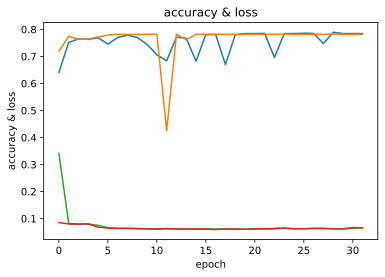

In [12]:
'''Training Auto-Encoder On Non-Fraud Partial Train data For Vizualization'''
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15),
    ModelCheckpoint(filepath='/tmp/autoenc.h5', monitor='val_loss', save_best_only=True),
    TensorBoard(log_dir='/tmp/log_dir', histogram_freq=0, write_graph=True, write_images=True)
]

model = auto_encoder(train_non_fraud.shape[1])
model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])
history = model.fit(train_non_fraud[:150000], train_non_fraud[:150000], 
    batch_size=1500, epochs=100, callbacks=callbacks, 
    shuffle=False, validation_split=0.25, verbose=1)
print(history.history.keys())
plot_history(history)

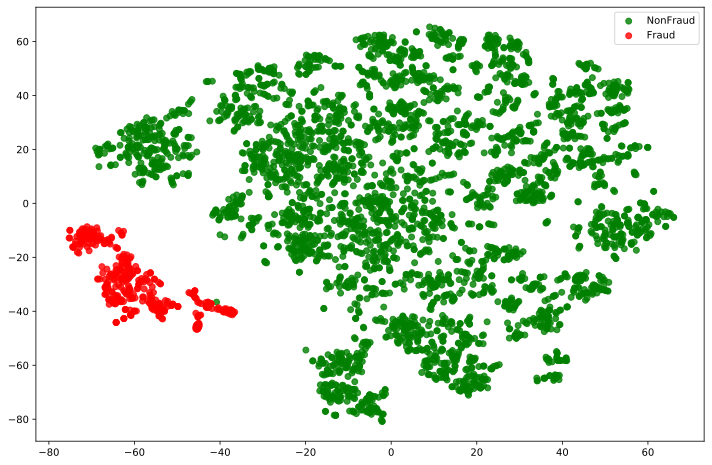

In [13]:
'''Encodeding Partial Train Data for Visualizing'''
encoder = encoder_form_auto_encoder(model)
encoded_fraud = encoder.predict(train_fraud)
encoded_non_fraud = encoder.predict(train_non_fraud[148000:152000])

x_viz = np.append(encoded_non_fraud, encoded_fraud, axis=0)
y_viz = np.append(
    np.zeros(encoded_non_fraud.shape[0]),
    np.ones(encoded_fraud.shape[0]) 
)
tnse_plot(x_viz, y_viz)

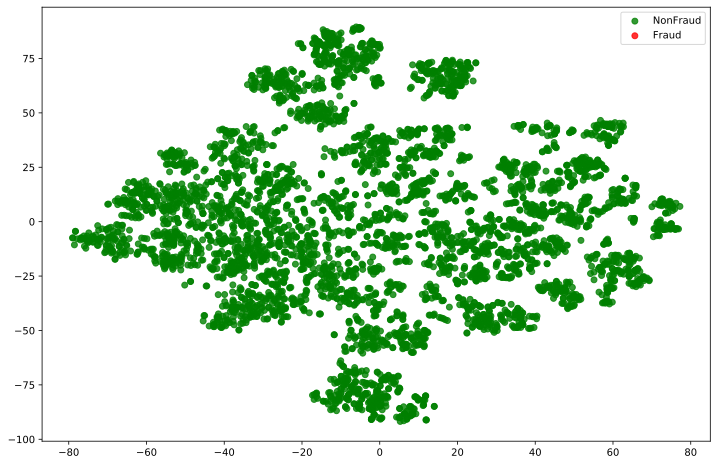

In [14]:
'''Encodeding Test Data Just for Visualizing before Predict'''
# Scaling Test data 
test_fraud, test_non_fraud = test_x[test_y == 1], test_x[test_y == 0]
test_fraud = preprocessing.MinMaxScaler().fit_transform(test_fraud)         #Can't do Feature Scalling Globally otherwise above line will break
test_non_fraud = preprocessing.MinMaxScaler().fit_transform(test_non_fraud)   

encoded_fraud = encoder.predict(test_fraud)
encoded_non_fraud = encoder.predict(test_non_fraud[5000:15000])
x_viz = np.append(encoded_non_fraud, encoded_fraud, axis=0)
y_viz = np.append(
    np.zeros(encoded_non_fraud.shape[0]),
    np.ones(encoded_fraud.shape[0]) 
)
tnse_plot(x_viz[3000:8000], y_viz[3000:8000])

In [15]:
def network(input_dim):
    nn = Sequential([
        Dense(units=64, activation='tanh',
            kernel_initializer = 'glorot_uniform',        
            activity_regularizer=regularizers.l2(0.001), 
            input_shape = (input_dim,)),
        Dense(units=64, activation='tanh'),
        Dense(units=1, activation='softmax'),
    ])
    return nn

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               6000      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_10 (Dense)             (None, 29)                5829      
Total params: 34,629
Trainable params: 34,629
Non-trainable params: 0
_________________________________________________________________
Train on 159919 samples, validate on 53307 samples
Epoch 1/150
 - 1s - loss: 0.3051 - acc: 0.7521 - val_loss: 0.0681 - val_acc: 0.6380
Epo

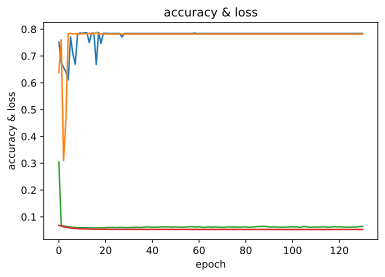

In [16]:
'''Solutioning'''
#1. Training Auto-Encoder On Complete Non-Fraud Train Data
model = auto_encoder(train_non_fraud.shape[1])
model.compile(optimizer='adadelta', loss='mse', metrics=['accuracy'])
history = model.fit(train_non_fraud, train_non_fraud, 
    batch_size=1500, epochs=150, callbacks=callbacks, 
    shuffle=False, validation_split=0.25, verbose=2)
plot_history(history)

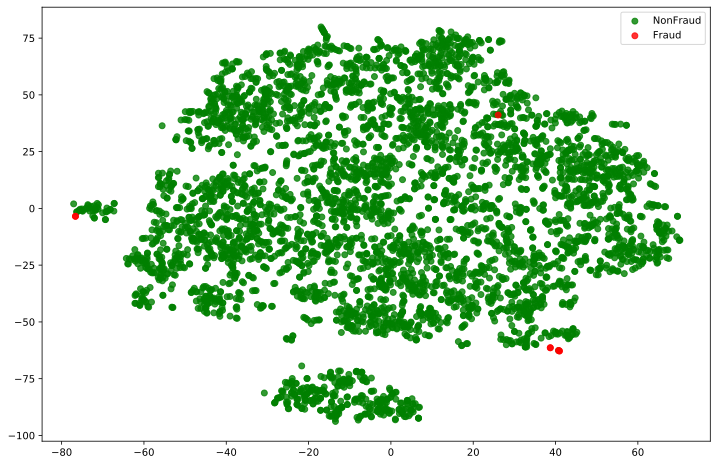

In [17]:
#2. Encoding Complete Train Data (Fraud + Non-Fraud)
encoder = encoder_form_auto_encoder(model)
norm_train_x = preprocessing.MinMaxScaler().fit_transform(train_x)
train_encoded = encoder.predict(norm_train_x)
tnse_plot(train_encoded[5000:10000], train_y[5000:10000])

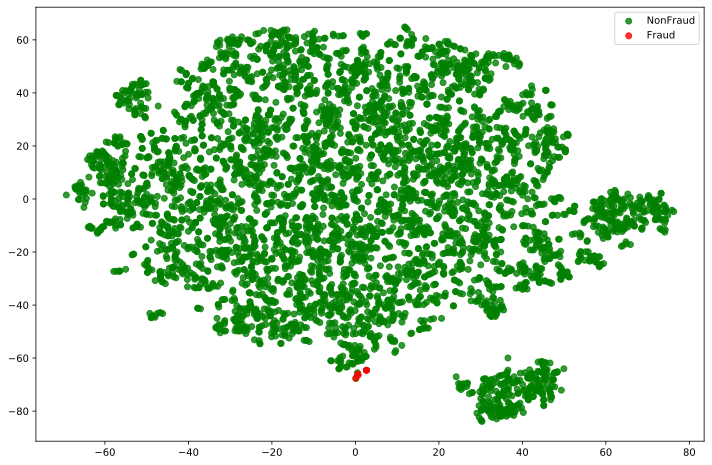

In [18]:
#3. Test Data AutoEncoder o/p Visualization
norm_test_x = preprocessing.MinMaxScaler().fit_transform(test_x)
test_autoencoder = model.predict(norm_test_x)
tnse_plot(test_autoencoder[25000:30000], test_y[25000:30000])

In [19]:
#4. Test Data AutoEncoder o/p Prediction Error Distribution
mse = np.mean((norm_test_x - test_autoencoder) ** 2, axis=1)
err_df = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': test_y
}).describe()

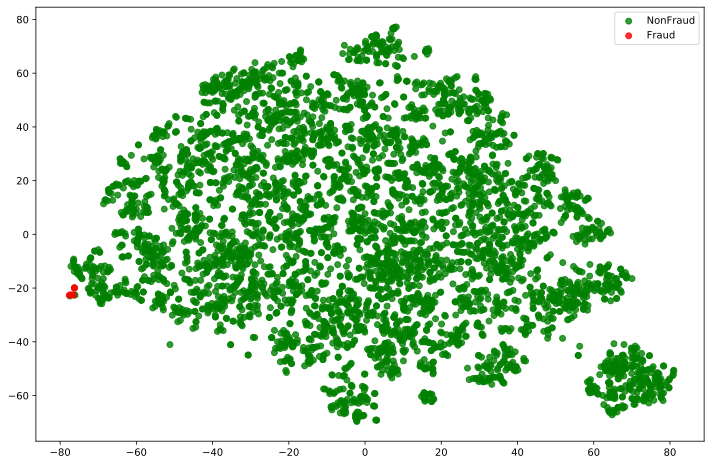

In [20]:
#5. Encode Test Data
test_encoder = encoder.predict(norm_test_x)
tnse_plot(test_encoder[25000:30000], test_y[25000:30000])

In [21]:
#6. Train SVM to Draw Boundary/Classify
from sklearn import svm, metrics
clf = svm.SVC(kernel='linear')
clf.fit(train_encoded, train_y)
predict = clf.predict(train_encoded)
print('Train Accuracy: ', metrics.accuracy_score(predict, train_y))

Train Accuracy:  0.9986938507993727


In [22]:
#7. Test Accuracy
predict = clf.predict(test_encoder)
print('Test Accuracy: ', metrics.accuracy_score(predict, test_y))
print('Test F1: ', metrics.f1_score(predict, test_y))
print('Confusion Matrix:\n', metrics.confusion_matrix(test_y, predict))

Test Accuracy:  0.9987500351113733
Test F1:  0.4183006535947712
Confusion Matrix:
 [[71081     8]
 [   81    32]]
